In [236]:
import os
import nltk
from nltk.util import ngrams
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from scipy.stats import ttest_rel

from tools.corpus_reader import CHILDESCorpusReader
from tools.functions import nansem, turns, turn_pairs
from tools.measures import dlg_mul, dlg_mwl, shared_ngrams, diff_matrix, \
conv_matrix, global_rate, local_rate

np.random.seed(42)

# read Brown corpus
nltk.data.path.append(os.getcwd() + '/data/nltk_data/')
corpus_root = nltk.data.find('corpora/childes/data-xml/Eng-USA')
brown = CHILDESCorpusReader(corpus_root, 'Brown/.*.xml')

# dialogue files for Adam and Sarah
adam_dlgs = [fileID for fileID in brown.fileids() if 'Adam' in fileID]
sarah_dlgs = [fileID for fileID in brown.fileids() if 'Sarah' in fileID]

## Extract turn pairs for all dialogues

In [237]:
# load from pickles
adam_sent_turn_pairs = pickle.load(open('data/pickles/adam_sent_turn-pairs.pkl', 'rb'))
adam_pos_turn_pairs = pickle.load(open('data/pickles/adam_pos_turn-pairs.pkl', 'rb'))
sarah_sent_turn_pairs = pickle.load(open('data/pickles/sarah_sent_turn-pairs.pkl', 'rb'))
sarah_pos_turn_pairs = pickle.load(open('data/pickles/sarah_pos_turn-pairs.pkl', 'rb'))

sarah_ages = list(sorted(sarah_sent_turn_pairs.keys()))
adam_ages = list(sorted(adam_sent_turn_pairs.keys()))

### Exclude turns
Exclude any turn pairs that have a turn with mean utterance length < 2.

28.067272727272734 % of Adam corpus excluded
49.63381294964029 % of Sarah corpus excluded


## Compute measures and matrices

In [6]:
# load from pickles
adam_measures = pickle.load(open('data/pickles/adam-measures.pkl', 'rb'))
sarah_measures = pickle.load(open('data/pickles/sarah-measures.pkl', 'rb'))

# Encoding sentences with BERT

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [01:05<00:00, 6.22MB/s] 


In [39]:
from scipy import spatial
def cosine_sim(vec1, vec2):
    distance = spatial.distance.cosine
    return 1 - distance(vec1,vec2)

A = list(model.encode(['I love the field of computational dialog modelling'])[0])
B = list(model.encode(['I really enjoy computationally modelling dialogue'])[0])

cosine_sim(A,B)

0.9048120975494385

In [110]:
import copy
sarah_sent_turn_vectors

def turn2Vec(corpus):
    sent_turn_vectors = copy.deepcopy(corpus)
    no_dialogues = len(corpus.keys())

    for i, age_key in enumerate(sent_turn_vectors.keys()):
        dialogue = sent_turn_vectors[age_key]
        for pair in dialogue:
            for turn in pair:
                sent = turn[-1][0]
                sent = [' '.join(sent)]
                sent = list(model.encode(sent)[0])
                turn[-1][0] = sent
        print("{} out of {} dialogues encoded".format(i+1, no_dialogues))
    return sent_turn_vectors

sarah_vectors = turn2Vec(sarah_sent_turn_pairs)
adam_vectors = turn2Vec(adam_sent_turn_pairs)

1 out of 139 dialogues encoded
2 out of 139 dialogues encoded
3 out of 139 dialogues encoded
4 out of 139 dialogues encoded
5 out of 139 dialogues encoded
6 out of 139 dialogues encoded
7 out of 139 dialogues encoded
8 out of 139 dialogues encoded
9 out of 139 dialogues encoded
10 out of 139 dialogues encoded
11 out of 139 dialogues encoded
12 out of 139 dialogues encoded
13 out of 139 dialogues encoded
14 out of 139 dialogues encoded
15 out of 139 dialogues encoded
16 out of 139 dialogues encoded
17 out of 139 dialogues encoded
18 out of 139 dialogues encoded
19 out of 139 dialogues encoded
20 out of 139 dialogues encoded
21 out of 139 dialogues encoded
22 out of 139 dialogues encoded
23 out of 139 dialogues encoded
24 out of 139 dialogues encoded
25 out of 139 dialogues encoded
26 out of 139 dialogues encoded
27 out of 139 dialogues encoded
28 out of 139 dialogues encoded
29 out of 139 dialogues encoded
30 out of 139 dialogues encoded
31 out of 139 dialogues encoded
32 out of 139 dia

In [116]:
pickle.dump(sarah_vectors, open('sarah_vectors.pkl', 'wb'))
pickle.dump(adam_vectors, open('adam_vectors.pkl', 'wb'))

In [238]:
adam_vectors = pickle.load(open('adam_vectors.pkl', 'rb'))
sarah_vectors = pickle.load(open('sarah_vectors.pkl', 'rb'))

In [239]:
def cosim_matrix(turn_pairs):
    """

    """
    
    N_pairs = len(turn_pairs)
    
    turns_j = [t[1] for t in turn_pairs]
    j_idx = np.repeat(np.arange(N_pairs), N_pairs)
    turns_i = [t[0] for t in turn_pairs]
    i_idx = np.tile(np.arange(N_pairs), N_pairs)
    
    m_vec = np.array([cosine_sim(turns_i[i][1][0], turns_j[j][1][0])
                      for j, i in zip(j_idx, i_idx)])
    
    m_mat = m_vec.reshape(N_pairs,N_pairs)
    
    return m_mat

In [203]:
example_matrix

array([[0.74413341, 0.64384544, 0.55073738, ..., 0.24832678, 0.29101411,
        0.51005596],
       [0.56849134, 0.68759179, 0.77328086, ..., 0.08737746, 0.33424306,
        0.70382637],
       [0.71858323, 0.61552817, 0.80526817, ..., 0.06946656, 0.28778741,
        0.77211839],
       ...,
       [0.62575758, 0.60495883, 0.85179102, ..., 0.02495422, 0.32561481,
        0.92661589],
       [0.50251138, 0.45011202, 0.49748343, ..., 0.15852724, 0.18434645,
        0.52641964],
       [0.48720098, 0.46215418, 0.41533574, ..., 0.23607293, 0.19866574,
        0.43450782]])

# Testing:

In [240]:
A = model.encode([' '.join(sarah_sent_turn_pairs[51.43][0][0][1][0])])[0]
B = model.encode([' '.join(sarah_sent_turn_pairs[51.43][0][1][1][0])])[0]
cosine_sim(A,B)

0.7441334128379822

## Plotting

In [245]:
len(sarah_vectors.keys())

139

In [397]:
def plot_rec_matrix(rec_mat, cmap, title, filename=False):
    """
    Plot recurrence matrix (like Fernandez & Grimm 2014, Fig.1)
    on alignment measures or on difference in complexity measures.
    """
    plt.figure()
    plt.imshow(rec_mat, cmap=cmap)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.xlabel('adult turns')
    plt.ylabel('child turns')
    plt.title(title)
    if filename:
        plt.savefig("figures/recurrence_plots/adam_semantic_281", dpi=300)
        plt.close()
    else:
        plt.show()

# age = 28.56
# subset = 99999
# for age in sorted(sarah_vectors.keys()):
#     pos_al = cosim_matrix(sarah_vectors[age])#[:subset, :subset]

#     plot_rec_matrix(pos_al, cmap='Greys', 
#                     title="Sarah: Cosine Similarity (age " + str(age) + ")")

In [398]:
pos_al = cosim_matrix(adam_vectors[28.1])

plot_rec_matrix(pos_al, cmap='Greys', 
                title="Adam: Cosine Similarity (age " + str(age) + ")", filename=True)

In [317]:
def local_rate(matrix, d, subset=None):
    """
    This should be RR_d
    """
    # we go over the diagonal of the matrix
    # i.e. consider all points (i, j) where i == j
    # and then we also take the points that are
    # d steps away (above or below) from the diagonal,
    # i.e. from (j, i-d) to (j, i+d)
    # over all those points, we take the mean
    
    # i is i-th turn by participant on the x-axis (adult)
    # j is j-th turn by participant on the y-axis (child)
    
    n = len(matrix)
    
    D = []
    
    # iterate over the diagonal
    for i, j in zip(range(n), range(n)):
        
        # only consider points where j > i
        if subset == 'pos':
            if i < d:
                D.extend(matrix[j, :i])
            else:
                D.extend(matrix[j, i-d:i])
            
        # only consider points where i > j
        elif subset == 'neg':
            if i < d:
                D.extend(matrix[j, i+1:i+1+d])
            else:
                D.extend(matrix[j, i+1:i+1+d])
            
        # consider points in both directions
        else:
            if i < d:
                D.extend(matrix[j, :i+d+1])
            else:
                D.extend(matrix[j, i-d:i+d+1])
                
    return np.nanmean(D)

# age = 28.56
# matrix = cosim_matrix(sarah_vectors[age])


def RR_over_time(turn_vectors, shuffle):
    RR_dict = {}
    for age in sorted(turn_vectors.keys()):
        if shuffle:
            matrix = cosim_matrix(turn_vectors[age])
            np.random.shuffle(matrix)
        else:
            matrix = cosim_matrix(turn_vectors[age])
        
        RR_dict[age] = {}
        for d in range(0, 11, 1):
            print('finished computing dialogue at age: {} RR for d: {}'.format(age, d))
            RR_dict[age][d] = local_rate(matrix=matrix, d=d)

    return RR_dict

# sarah_RRs = []
# for d in range(0, 11, 1):
#     sarah_RR = RR_over_time(sarah_vectors,d)
#     sarah_RRs.append(sarah_RR)
#     print('finished computing RR for d: {}'.format(d))

sarah_RRs_shf = RR_over_time(sarah_vectors, shuffle=True)

finished computing dialogue at age: 27.16 RR for d: 0
finished computing dialogue at age: 27.16 RR for d: 1
finished computing dialogue at age: 27.16 RR for d: 2
finished computing dialogue at age: 27.16 RR for d: 3
finished computing dialogue at age: 27.16 RR for d: 4
finished computing dialogue at age: 27.16 RR for d: 5
finished computing dialogue at age: 27.16 RR for d: 6
finished computing dialogue at age: 27.16 RR for d: 7
finished computing dialogue at age: 27.16 RR for d: 8
finished computing dialogue at age: 27.16 RR for d: 9
finished computing dialogue at age: 27.16 RR for d: 10
finished computing dialogue at age: 27.23 RR for d: 0
finished computing dialogue at age: 27.23 RR for d: 1
finished computing dialogue at age: 27.23 RR for d: 2
finished computing dialogue at age: 27.23 RR for d: 3
finished computing dialogue at age: 27.23 RR for d: 4
finished computing dialogue at age: 27.23 RR for d: 5
finished computing dialogue at age: 27.23 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 29.99 RR for d: 0
finished computing dialogue at age: 29.99 RR for d: 1
finished computing dialogue at age: 29.99 RR for d: 2
finished computing dialogue at age: 29.99 RR for d: 3
finished computing dialogue at age: 29.99 RR for d: 4
finished computing dialogue at age: 29.99 RR for d: 5
finished computing dialogue at age: 29.99 RR for d: 6
finished computing dialogue at age: 29.99 RR for d: 7
finished computing dialogue at age: 29.99 RR for d: 8
finished computing dialogue at age: 29.99 RR for d: 9
finished computing dialogue at age: 29.99 RR for d: 10
finished computing dialogue at age: 30.13 RR for d: 0
finished computing dialogue at age: 30.13 RR for d: 1
finished computing dialogue at age: 30.13 RR for d: 2
finished computing dialogue at age: 30.13 RR for d: 3
finished computing dialogue at age: 30.13 RR for d: 4
finished computing dialogue at age: 30.13 RR for d: 5
finished computing dialogue at age: 30.13 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 33.46 RR for d: 0
finished computing dialogue at age: 33.46 RR for d: 1
finished computing dialogue at age: 33.46 RR for d: 2
finished computing dialogue at age: 33.46 RR for d: 3
finished computing dialogue at age: 33.46 RR for d: 4
finished computing dialogue at age: 33.46 RR for d: 5
finished computing dialogue at age: 33.46 RR for d: 6
finished computing dialogue at age: 33.46 RR for d: 7
finished computing dialogue at age: 33.46 RR for d: 8
finished computing dialogue at age: 33.46 RR for d: 9
finished computing dialogue at age: 33.46 RR for d: 10
finished computing dialogue at age: 33.66 RR for d: 0
finished computing dialogue at age: 33.66 RR for d: 1
finished computing dialogue at age: 33.66 RR for d: 2
finished computing dialogue at age: 33.66 RR for d: 3
finished computing dialogue at age: 33.66 RR for d: 4
finished computing dialogue at age: 33.66 RR for d: 5
finished computing dialogue at age: 33.66 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 37.1 RR for d: 0
finished computing dialogue at age: 37.1 RR for d: 1
finished computing dialogue at age: 37.1 RR for d: 2
finished computing dialogue at age: 37.1 RR for d: 3
finished computing dialogue at age: 37.1 RR for d: 4
finished computing dialogue at age: 37.1 RR for d: 5
finished computing dialogue at age: 37.1 RR for d: 6
finished computing dialogue at age: 37.1 RR for d: 7
finished computing dialogue at age: 37.1 RR for d: 8
finished computing dialogue at age: 37.1 RR for d: 9
finished computing dialogue at age: 37.1 RR for d: 10
finished computing dialogue at age: 37.33 RR for d: 0
finished computing dialogue at age: 37.33 RR for d: 1
finished computing dialogue at age: 37.33 RR for d: 2
finished computing dialogue at age: 37.33 RR for d: 3
finished computing dialogue at age: 37.33 RR for d: 4
finished computing dialogue at age: 37.33 RR for d: 5
finished computing dialogue at age: 37.33 RR for d: 6
finished computing dialogue at age: 37

finished computing dialogue at age: 40.3 RR for d: 0
finished computing dialogue at age: 40.3 RR for d: 1
finished computing dialogue at age: 40.3 RR for d: 2
finished computing dialogue at age: 40.3 RR for d: 3
finished computing dialogue at age: 40.3 RR for d: 4
finished computing dialogue at age: 40.3 RR for d: 5
finished computing dialogue at age: 40.3 RR for d: 6
finished computing dialogue at age: 40.3 RR for d: 7
finished computing dialogue at age: 40.3 RR for d: 8
finished computing dialogue at age: 40.3 RR for d: 9
finished computing dialogue at age: 40.3 RR for d: 10
finished computing dialogue at age: 40.53 RR for d: 0
finished computing dialogue at age: 40.53 RR for d: 1
finished computing dialogue at age: 40.53 RR for d: 2
finished computing dialogue at age: 40.53 RR for d: 3
finished computing dialogue at age: 40.53 RR for d: 4
finished computing dialogue at age: 40.53 RR for d: 5
finished computing dialogue at age: 40.53 RR for d: 6
finished computing dialogue at age: 40

finished computing dialogue at age: 43.99 RR for d: 0
finished computing dialogue at age: 43.99 RR for d: 1
finished computing dialogue at age: 43.99 RR for d: 2
finished computing dialogue at age: 43.99 RR for d: 3
finished computing dialogue at age: 43.99 RR for d: 4
finished computing dialogue at age: 43.99 RR for d: 5
finished computing dialogue at age: 43.99 RR for d: 6
finished computing dialogue at age: 43.99 RR for d: 7
finished computing dialogue at age: 43.99 RR for d: 8
finished computing dialogue at age: 43.99 RR for d: 9
finished computing dialogue at age: 43.99 RR for d: 10
finished computing dialogue at age: 44.2 RR for d: 0
finished computing dialogue at age: 44.2 RR for d: 1
finished computing dialogue at age: 44.2 RR for d: 2
finished computing dialogue at age: 44.2 RR for d: 3
finished computing dialogue at age: 44.2 RR for d: 4
finished computing dialogue at age: 44.2 RR for d: 5
finished computing dialogue at age: 44.2 RR for d: 6
finished computing dialogue at age

finished computing dialogue at age: 47.53 RR for d: 0
finished computing dialogue at age: 47.53 RR for d: 1
finished computing dialogue at age: 47.53 RR for d: 2
finished computing dialogue at age: 47.53 RR for d: 3
finished computing dialogue at age: 47.53 RR for d: 4
finished computing dialogue at age: 47.53 RR for d: 5
finished computing dialogue at age: 47.53 RR for d: 6
finished computing dialogue at age: 47.53 RR for d: 7
finished computing dialogue at age: 47.53 RR for d: 8
finished computing dialogue at age: 47.53 RR for d: 9
finished computing dialogue at age: 47.53 RR for d: 10
finished computing dialogue at age: 47.95 RR for d: 0
finished computing dialogue at age: 47.95 RR for d: 1
finished computing dialogue at age: 47.95 RR for d: 2
finished computing dialogue at age: 47.95 RR for d: 3
finished computing dialogue at age: 47.95 RR for d: 4
finished computing dialogue at age: 47.95 RR for d: 5
finished computing dialogue at age: 47.95 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 51.23 RR for d: 0
finished computing dialogue at age: 51.23 RR for d: 1
finished computing dialogue at age: 51.23 RR for d: 2
finished computing dialogue at age: 51.23 RR for d: 3
finished computing dialogue at age: 51.23 RR for d: 4
finished computing dialogue at age: 51.23 RR for d: 5
finished computing dialogue at age: 51.23 RR for d: 6
finished computing dialogue at age: 51.23 RR for d: 7
finished computing dialogue at age: 51.23 RR for d: 8
finished computing dialogue at age: 51.23 RR for d: 9
finished computing dialogue at age: 51.23 RR for d: 10
finished computing dialogue at age: 51.43 RR for d: 0
finished computing dialogue at age: 51.43 RR for d: 1
finished computing dialogue at age: 51.43 RR for d: 2
finished computing dialogue at age: 51.43 RR for d: 3
finished computing dialogue at age: 51.43 RR for d: 4
finished computing dialogue at age: 51.43 RR for d: 5
finished computing dialogue at age: 51.43 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 54.33 RR for d: 0
finished computing dialogue at age: 54.33 RR for d: 1
finished computing dialogue at age: 54.33 RR for d: 2
finished computing dialogue at age: 54.33 RR for d: 3
finished computing dialogue at age: 54.33 RR for d: 4
finished computing dialogue at age: 54.33 RR for d: 5
finished computing dialogue at age: 54.33 RR for d: 6
finished computing dialogue at age: 54.33 RR for d: 7
finished computing dialogue at age: 54.33 RR for d: 8
finished computing dialogue at age: 54.33 RR for d: 9
finished computing dialogue at age: 54.33 RR for d: 10
finished computing dialogue at age: 54.56 RR for d: 0
finished computing dialogue at age: 54.56 RR for d: 1
finished computing dialogue at age: 54.56 RR for d: 2
finished computing dialogue at age: 54.56 RR for d: 3
finished computing dialogue at age: 54.56 RR for d: 4
finished computing dialogue at age: 54.56 RR for d: 5
finished computing dialogue at age: 54.56 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 58.2 RR for d: 0
finished computing dialogue at age: 58.2 RR for d: 1
finished computing dialogue at age: 58.2 RR for d: 2
finished computing dialogue at age: 58.2 RR for d: 3
finished computing dialogue at age: 58.2 RR for d: 4
finished computing dialogue at age: 58.2 RR for d: 5
finished computing dialogue at age: 58.2 RR for d: 6
finished computing dialogue at age: 58.2 RR for d: 7
finished computing dialogue at age: 58.2 RR for d: 8
finished computing dialogue at age: 58.2 RR for d: 9
finished computing dialogue at age: 58.2 RR for d: 10
finished computing dialogue at age: 58.69 RR for d: 0
finished computing dialogue at age: 58.69 RR for d: 1
finished computing dialogue at age: 58.69 RR for d: 2
finished computing dialogue at age: 58.69 RR for d: 3
finished computing dialogue at age: 58.69 RR for d: 4
finished computing dialogue at age: 58.69 RR for d: 5
finished computing dialogue at age: 58.69 RR for d: 6
finished computing dialogue at age: 58

In [324]:
adam_RRs = RR_over_time(adam_vectors, shuffle=False)
adam_RRs_shf = RR_over_time(adam_vectors, shuffle=True)

finished computing dialogue at age: 27.13 RR for d: 0
finished computing dialogue at age: 27.13 RR for d: 1
finished computing dialogue at age: 27.13 RR for d: 2
finished computing dialogue at age: 27.13 RR for d: 3
finished computing dialogue at age: 27.13 RR for d: 4
finished computing dialogue at age: 27.13 RR for d: 5
finished computing dialogue at age: 27.13 RR for d: 6
finished computing dialogue at age: 27.13 RR for d: 7
finished computing dialogue at age: 27.13 RR for d: 8
finished computing dialogue at age: 27.13 RR for d: 9
finished computing dialogue at age: 27.13 RR for d: 10
finished computing dialogue at age: 27.59 RR for d: 0
finished computing dialogue at age: 27.59 RR for d: 1
finished computing dialogue at age: 27.59 RR for d: 2
finished computing dialogue at age: 27.59 RR for d: 3
finished computing dialogue at age: 27.59 RR for d: 4
finished computing dialogue at age: 27.59 RR for d: 5
finished computing dialogue at age: 27.59 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 34.07 RR for d: 0
finished computing dialogue at age: 34.07 RR for d: 1
finished computing dialogue at age: 34.07 RR for d: 2
finished computing dialogue at age: 34.07 RR for d: 3
finished computing dialogue at age: 34.07 RR for d: 4
finished computing dialogue at age: 34.07 RR for d: 5
finished computing dialogue at age: 34.07 RR for d: 6
finished computing dialogue at age: 34.07 RR for d: 7
finished computing dialogue at age: 34.07 RR for d: 8
finished computing dialogue at age: 34.07 RR for d: 9
finished computing dialogue at age: 34.07 RR for d: 10
finished computing dialogue at age: 34.53 RR for d: 0
finished computing dialogue at age: 34.53 RR for d: 1
finished computing dialogue at age: 34.53 RR for d: 2
finished computing dialogue at age: 34.53 RR for d: 3
finished computing dialogue at age: 34.53 RR for d: 4
finished computing dialogue at age: 34.53 RR for d: 5
finished computing dialogue at age: 34.53 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 40.59 RR for d: 0
finished computing dialogue at age: 40.59 RR for d: 1
finished computing dialogue at age: 40.59 RR for d: 2
finished computing dialogue at age: 40.59 RR for d: 3
finished computing dialogue at age: 40.59 RR for d: 4
finished computing dialogue at age: 40.59 RR for d: 5
finished computing dialogue at age: 40.59 RR for d: 6
finished computing dialogue at age: 40.59 RR for d: 7
finished computing dialogue at age: 40.59 RR for d: 8
finished computing dialogue at age: 40.59 RR for d: 9
finished computing dialogue at age: 40.59 RR for d: 10
finished computing dialogue at age: 41.03 RR for d: 0
finished computing dialogue at age: 41.03 RR for d: 1
finished computing dialogue at age: 41.03 RR for d: 2
finished computing dialogue at age: 41.03 RR for d: 3
finished computing dialogue at age: 41.03 RR for d: 4
finished computing dialogue at age: 41.03 RR for d: 5
finished computing dialogue at age: 41.03 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 49.49 RR for d: 0
finished computing dialogue at age: 49.49 RR for d: 1
finished computing dialogue at age: 49.49 RR for d: 2
finished computing dialogue at age: 49.49 RR for d: 3
finished computing dialogue at age: 49.49 RR for d: 4
finished computing dialogue at age: 49.49 RR for d: 5
finished computing dialogue at age: 49.49 RR for d: 6
finished computing dialogue at age: 49.49 RR for d: 7
finished computing dialogue at age: 49.49 RR for d: 8
finished computing dialogue at age: 49.49 RR for d: 9
finished computing dialogue at age: 49.49 RR for d: 10
finished computing dialogue at age: 50.56 RR for d: 0
finished computing dialogue at age: 50.56 RR for d: 1
finished computing dialogue at age: 50.56 RR for d: 2
finished computing dialogue at age: 50.56 RR for d: 3
finished computing dialogue at age: 50.56 RR for d: 4
finished computing dialogue at age: 50.56 RR for d: 5
finished computing dialogue at age: 50.56 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 27.59 RR for d: 0
finished computing dialogue at age: 27.59 RR for d: 1
finished computing dialogue at age: 27.59 RR for d: 2
finished computing dialogue at age: 27.59 RR for d: 3
finished computing dialogue at age: 27.59 RR for d: 4
finished computing dialogue at age: 27.59 RR for d: 5
finished computing dialogue at age: 27.59 RR for d: 6
finished computing dialogue at age: 27.59 RR for d: 7
finished computing dialogue at age: 27.59 RR for d: 8
finished computing dialogue at age: 27.59 RR for d: 9
finished computing dialogue at age: 27.59 RR for d: 10
finished computing dialogue at age: 28.1 RR for d: 0
finished computing dialogue at age: 28.1 RR for d: 1
finished computing dialogue at age: 28.1 RR for d: 2
finished computing dialogue at age: 28.1 RR for d: 3
finished computing dialogue at age: 28.1 RR for d: 4
finished computing dialogue at age: 28.1 RR for d: 5
finished computing dialogue at age: 28.1 RR for d: 6
finished computing dialogue at age

finished computing dialogue at age: 34.53 RR for d: 0
finished computing dialogue at age: 34.53 RR for d: 1
finished computing dialogue at age: 34.53 RR for d: 2
finished computing dialogue at age: 34.53 RR for d: 3
finished computing dialogue at age: 34.53 RR for d: 4
finished computing dialogue at age: 34.53 RR for d: 5
finished computing dialogue at age: 34.53 RR for d: 6
finished computing dialogue at age: 34.53 RR for d: 7
finished computing dialogue at age: 34.53 RR for d: 8
finished computing dialogue at age: 34.53 RR for d: 9
finished computing dialogue at age: 34.53 RR for d: 10
finished computing dialogue at age: 34.99 RR for d: 0
finished computing dialogue at age: 34.99 RR for d: 1
finished computing dialogue at age: 34.99 RR for d: 2
finished computing dialogue at age: 34.99 RR for d: 3
finished computing dialogue at age: 34.99 RR for d: 4
finished computing dialogue at age: 34.99 RR for d: 5
finished computing dialogue at age: 34.99 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 41.03 RR for d: 0
finished computing dialogue at age: 41.03 RR for d: 1
finished computing dialogue at age: 41.03 RR for d: 2
finished computing dialogue at age: 41.03 RR for d: 3
finished computing dialogue at age: 41.03 RR for d: 4
finished computing dialogue at age: 41.03 RR for d: 5
finished computing dialogue at age: 41.03 RR for d: 6
finished computing dialogue at age: 41.03 RR for d: 7
finished computing dialogue at age: 41.03 RR for d: 8
finished computing dialogue at age: 41.03 RR for d: 9
finished computing dialogue at age: 41.03 RR for d: 10
finished computing dialogue at age: 41.49 RR for d: 0
finished computing dialogue at age: 41.49 RR for d: 1
finished computing dialogue at age: 41.49 RR for d: 2
finished computing dialogue at age: 41.49 RR for d: 3
finished computing dialogue at age: 41.49 RR for d: 4
finished computing dialogue at age: 41.49 RR for d: 5
finished computing dialogue at age: 41.49 RR for d: 6
finished computing dialogue

finished computing dialogue at age: 50.56 RR for d: 0
finished computing dialogue at age: 50.56 RR for d: 1
finished computing dialogue at age: 50.56 RR for d: 2
finished computing dialogue at age: 50.56 RR for d: 3
finished computing dialogue at age: 50.56 RR for d: 4
finished computing dialogue at age: 50.56 RR for d: 5
finished computing dialogue at age: 50.56 RR for d: 6
finished computing dialogue at age: 50.56 RR for d: 7
finished computing dialogue at age: 50.56 RR for d: 8
finished computing dialogue at age: 50.56 RR for d: 9
finished computing dialogue at age: 50.56 RR for d: 10
finished computing dialogue at age: 51.3 RR for d: 0
finished computing dialogue at age: 51.3 RR for d: 1
finished computing dialogue at age: 51.3 RR for d: 2
finished computing dialogue at age: 51.3 RR for d: 3
finished computing dialogue at age: 51.3 RR for d: 4
finished computing dialogue at age: 51.3 RR for d: 5
finished computing dialogue at age: 51.3 RR for d: 6
finished computing dialogue at age

In [325]:
pickle.dump(sarah_RRs, open('sarah_RRs.pkl', 'wb'))
pickle.dump(sarah_RRs_shf, open('sarah_RRs_shf.pkl', 'wb'))
pickle.dump(adam_RRs, open('adam_RRs.pkl', 'wb'))
pickle.dump(adam_RRs_shf, open('adam_RRs_shf.pkl', 'wb'))

In [318]:
def dict_2_list(dictionary):
    RR_per_d = [[],[],[],[],[],[],[],[],[],[],[]]

    for age in sorted(dictionary.keys()):
        for d in sorted(dictionary[age].keys()):
            RR_per_d[d].append(dictionary[age][d])
    return RR_per_d

Sarah_per_d = dict_2_list(sarah_RRs)
Sarah_per_d_shf = dict_2_list(sarah_RRs_shf)

In [326]:
Adam_per_d = dict_2_list(adam_RRs)
Adam_per_d_shf = dict_2_list(adam_RRs_shf)

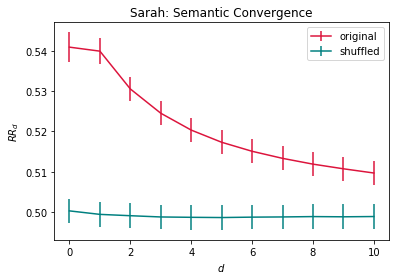

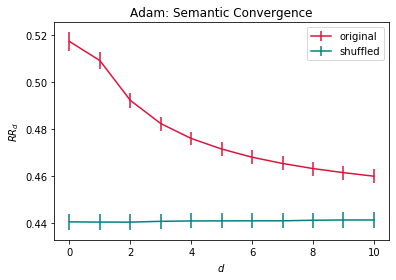

In [330]:
def plot_locRR(locRR, locRR_shf, title, filename=False):
    """
    Plot the local RR (averaged over all dialogues) at different
    levels of d in original vs. shuffled dialogues.
    (see Fernandez & Grimm 2014, Fig. 2)
    """
    plt.figure()
    xs = [int(d) for d in range(0,11)]
    y = [np.mean(locRR[d]) for d in range(0,11)]
    yerr = [nansem(locRR[d]) for d in range(0,11)]
    
    y_shf = [np.mean(locRR_shf[d]) for d in range(0,11)]
    yerr_shf = [nansem(locRR_shf[d]) for d in range(0,11)]
    plt.errorbar(xs, y, yerr, color='crimson', label='original')
    plt.errorbar(xs, y_shf, yerr_shf, color='teal', label='shuffled')
    plt.xlabel('$d$')
    plt.ylabel('$RR_d$')
    plt.title(title)
    plt.legend()
    if filename:
        plt.savefig("figures/local_RR/" + filename, dpi=300)
        plt.close()
    else:
        plt.show()

locRR = Sarah_per_d
locRR_shf = Sarah_per_d_shf
    
plot_locRR(Sarah_per_d, Sarah_per_d_shf, title="Sarah: Semantic Convergence")#, filename="sarah_convergence")
plot_locRR(Adam_per_d, Adam_per_d_shf, title="Adam: Semantic Convergence")#, filename="adam_convergence")

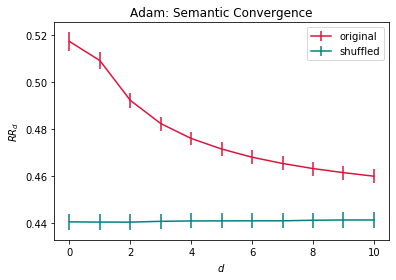

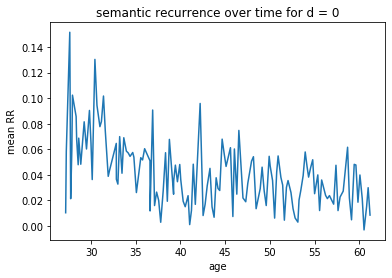

In [372]:
ages = []
convergence = []
d=0
for age in sorted(sarah_RRs.keys()):
    ages.append(age)
    convergence.append(sarah_RRs[age][d]-sarah_RRs_shf[age][d])

x = ages
y = convergence
plt.figure()
plt.title('semantic recurrence over time for d = 0')
plt.xlabel('age')
plt.ylabel('mean RR')
plt.plot(x,y)

In [338]:
adam_RRs

{27.13: {0: 0.5574871449413912,
  1: 0.5103275867651648,
  2: 0.48444471173322523,
  3: 0.47332230226632277,
  4: 0.46563747188672344,
  5: 0.45926327921171073,
  6: 0.4549225107785367,
  7: 0.45170511955479115,
  8: 0.44874022622009857,
  9: 0.4468193479438182,
  10: 0.44513316606946013},
 27.59: {0: 0.5612635340196667,
  1: 0.525032156748566,
  2: 0.49713821414306364,
  3: 0.4822173615441892,
  4: 0.4731964041790174,
  5: 0.46632319496721564,
  6: 0.46138285395115275,
  7: 0.4574116053748174,
  8: 0.45366062116138917,
  9: 0.4505517373755739,
  10: 0.44794798153502335},
 28.1: {0: 0.5434047200404812,
  1: 0.5187131876125932,
  2: 0.48979703537946273,
  3: 0.4734248051052842,
  4: 0.46103339567446283,
  5: 0.4525675160069988,
  6: 0.4471871478844629,
  7: 0.44184688635939756,
  8: 0.43639626922553054,
  9: 0.4326880437336484,
  10: 0.4293996376419046},
 28.49: {0: 0.5658634455084508,
  1: 0.5325034676271703,
  2: 0.50573718638709,
  3: 0.48974305933309464,
  4: 0.47980888727980714,
  

### Convergence in complexity

### Local RR for varying d
(something resembling Fig. 2 from Fernandez & Grimm 2014)

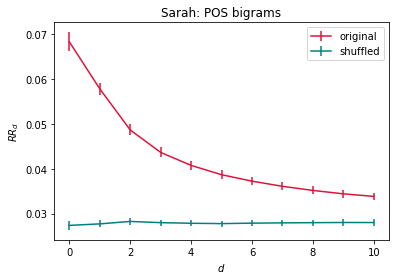

In [11]:
def plot_locRR(locRR, locRR_shf, title, filename=False):
    """
    Plot the local RR (averaged over all dialogues) at different
    levels of d in original vs. shuffled dialogues.
    (see Fernandez & Grimm 2014, Fig. 2)
    """
    plt.figure()
    xs = [int(d) for d in sorted(locRR.keys())]
    y = [np.mean(locRR[d]) for d in sorted(locRR.keys())]
    yerr = [nansem(locRR[d]) for d in sorted(locRR.keys())]
    
    y_shf = [np.mean(locRR_shf[d]) for d in sorted(locRR_shf.keys())]
    yerr_shf = [nansem(locRR_shf[d]) for d in sorted(locRR_shf.keys())]
    plt.errorbar(xs, y, yerr, color='crimson', label='original')
    plt.errorbar(xs, y_shf, yerr_shf, color='teal', label='shuffled')
    plt.xlabel('$d$')
    plt.ylabel('$RR_d$')
    plt.title(title)
    plt.legend()
    if filename:
        plt.savefig("figures/local_RR/" + filename, dpi=300)
        plt.close()
    else:
        plt.show()

locRR = sarah_RRs
locRR_shf = sarah_measures['PosBi']['shLocRR']
    
plot_locRR(locRR, locRR_shf, title="Sarah: POS bigrams")

### Paired t-tests for positive & negative RR_2

Fernandez & Grimm 2014, Table 3

Is recurrence significantly higher when the adult's turn follows the child's?

In [12]:
# Mean word length: no
mwl_RR2pos = sarah_measures['MWL']['RR2pos']
mwl_RR2neg = sarah_measures['MWL']['RR2neg']
ttest_rel(mwl_RR2pos, mwl_RR2neg)

Ttest_relResult(statistic=-0.7267495820162329, pvalue=0.4686103516614166)

In [13]:
# Mean utterance length: no
mul_RR2pos = sarah_measures['MUL']['RR2pos']
mul_RR2neg = sarah_measures['MUL']['RR2neg']
ttest_rel(mul_RR2pos, mul_RR2neg)

Ttest_relResult(statistic=0.1491295573253919, pvalue=0.8816691165858854)

In [14]:
# Lexeme unigrams: yes!
# RR2pos is significantly smaller than RR2neg
# because t < 0; this is a 2-tailed test, for 1-tailed divide p by 2
lexuni_RR2pos = sarah_measures['LexUni']['RR2pos']
lexuni_RR2neg = sarah_measures['LexUni']['RR2neg']
ttest_rel(lexuni_RR2pos, lexuni_RR2neg)

Ttest_relResult(statistic=-23.881675539884725, pvalue=7.290067041154482e-51)

In [15]:
# Lexeme bigrams: yes!
# RR2pos is significantly smaller than RR2neg
# because t < 0; this is a 2-tailed test, for 1-tailed divide p by 2
lexbi_RR2pos = sarah_measures['LexBi']['RR2pos']
lexbi_RR2neg = sarah_measures['LexBi']['RR2neg']
ttest_rel(lexbi_RR2pos, lexbi_RR2neg)

Ttest_relResult(statistic=-17.747828094965453, pvalue=1.9525788099178286e-37)

In [16]:
# POS bigrams: yes!
# RR2pos is significantly smaller than RR2neg
# because t < 0; this is a 2-tailed test, for 1-tailed divide p by 2
posbi_RR2pos = sarah_measures['PosBi']['RR2pos']
posbi_RR2neg = sarah_measures['PosBi']['RR2neg']
ttest_rel(posbi_RR2pos, posbi_RR2neg)

Ttest_relResult(statistic=-17.568316765840326, pvalue=5.1794593519666375e-37)

### Plot all the plots!!!
Save to figures directory

In [17]:
# child_name = 'Adam'
# child_ages = adam_ages
# measures = adam_measures

# # complexity convergence
# plot_chi_adt(measures['MWL']['CHI'], measures['MWL']['ADT'], 
#              'MWL', title=child_name + ": Child vs. Adult word lengths",
#              filename=child_name + "_CHI-ADT_MWL.png")
# plot_chi_adt(measures['MUL']['CHI'], measures['MUL']['ADT'], 
#              'MUL', title=child_name + ": Child vs. Adult utterance lengths",
#              filename=child_name + "_CHI-ADT_MUL.png")
# plot_chi_adt_time(child_ages, measures['MWL']['CHI'], measures['MWL']['ADT'], 
#                   'MWL', title=child_name + ": Mean word length over time",
#                   filename=child_name + "_CHI-ADT_time_MWL.png")
# plot_chi_adt_time(child_ages, measures['MUL']['CHI'], measures['MUL']['ADT'], 
#                   'MUL', title=child_name + ": Mean utterance length over time",
#                   filename=child_name + "_CHI-ADT_time_MUL.png")

# # global recurrence over time
# plot_globRR(child_ages, measures['MWL']['GlobRR'], 'MWL',
#             title=child_name + ": Global MWL recurrence over time",
#             filename=child_name + "_globRR_MWL.png")
# plot_globRR(child_ages, measures['MUL']['GlobRR'], 'MUL',
#             title=child_name + ": Global MUL recurrence over time",
#             filename=child_name + "_globRR_MUL.png")
# plot_globRR(child_ages, measures['LexUni']['GlobRR'], 'Lexeme Unigrams',
#             title=child_name + ": Global Lexeme Unigram recurrence over time",
#             filename=child_name + "_globRR_LexUni.png")
# plot_globRR(child_ages, measures['LexBi']['GlobRR'], 'Lexeme Bigrams',
#             title=child_name + ": Global Lexeme Bigram recurrence over time",
#             filename=child_name + "_globRR_LexBi.png")
# plot_globRR(child_ages, measures['PosBi']['GlobRR'], 'POS Bigrams',
#             title=child_name + ": Global POS Bigram recurrence over time",
#             filename=child_name + "_globRR_PosBi.png")

# # recurrence plots
# for age in child_ages:
#     plot_rec_matrix(measures['MWL']['matrix'][age], cmap='RdYlGn',
#                     title=child_name + ": Mean word length (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/MWL_" + str(round(age,2)) + ".png")
#     plot_rec_matrix(measures['MUL']['matrix'][age], cmap='RdYlGn',
#                     title=child_name + ": Mean utterance length (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/MUL_" + str(round(age,2)) + ".png")
    
#     plot_rec_matrix(measures['LexUni']['matrix'][age], cmap='Greys',
#                     title=child_name + ": Lexeme Unigrams (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/LexUni_" + str(round(age,2)) + ".png")
#     plot_rec_matrix(measures['LexBi']['matrix'][age], cmap='Greys',
#                     title=child_name + ": Lexeme Bigrams (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/LexBi_" + str(round(age,2)) + ".png")
#     plot_rec_matrix(measures['PosBi']['matrix'][age], cmap='Greys',
#                     title=child_name + ": POS Bigrams (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/PosBi_" + str(round(age,2)) + ".png")
    
# # local RR for varying d
# plot_locRR(measures['MWL']['LocRR'], measures['MWL']['shLocRR'], 
#            title=child_name + ": Mean word length",
#            filename=child_name + "_locRR_MWL.png")
# plot_locRR(measures['MUL']['LocRR'], measures['MUL']['shLocRR'], 
#            title=child_name + ": Mean utterance length",
#            filename=child_name + "_locRR_MUL.png")
# plot_locRR(measures['LexUni']['LocRR'], measures['LexUni']['shLocRR'], 
#            title=child_name + ": Lexical Unigrams",
#            filename=child_name + "_locRR_LexUni.png")
# plot_locRR(measures['LexBi']['LocRR'], measures['LexBi']['shLocRR'], 
#            title=child_name + ": Lexical Bigrams",
#            filename=child_name + "_locRR_LexBi.png")
# plot_locRR(measures['PosBi']['LocRR'], measures['PosBi']['shLocRR'], 
#            title=child_name + ": POS Bigrams",
#            filename=child_name + "_locRR_PosBi.png")

In [ ]:
# name = 'sarah'
# dlg_files = sarah_dlgs
# sent_turn_pairs = sarah_sent_turn_pairs
# postag_turn_pairs = sarah_pos_turn_pairs
# excl_idx = sarah_excl_idx

# d_range = range(11)

# measures = {'ages': [],
#             'MWL': {'CHI': [], 'ADT': [], 
#                     'matrix': {}, 'shuffled': {},
#                     'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                     'LocRR': {d: [] for d in d_range},
#                     'shLocRR': {d: [] for d in d_range}},
#             'MUL': {'CHI': [], 'ADT': [], 
#                     'matrix': {}, 'shuffled': {},
#                     'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                     'LocRR': {d: [] for d in d_range},
#                     'shLocRR': {d: [] for d in d_range}},
#             'LexUni': {'matrix': {}, 'shuffled': {},
#                        'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                        'LocRR': {d: [] for d in d_range},
#                        'shLocRR': {d: [] for d in d_range}},
#             'LexBi': {'matrix': {}, 'shuffled': {},
#                       'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                       'LocRR': {d: [] for d in d_range},
#                       'shLocRR': {d: [] for d in d_range}},
#             'PosBi': {'matrix': {}, 'shuffled': {},
#                       'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                       'LocRR': {d: [] for d in d_range},
#                       'shLocRR': {d: [] for d in d_range}}}

# for dlg_file in dlg_files:
    
#     # get dialogue sentences and POS tags
#     dlg_sents = brown.sents(dlg_file)
#     tagged_sents = brown.tagged_sents(dlg_file)
#     dlg_postags = [[spkID, [w[1] for w in utt]]
#               for spkID, utt in tagged_sents]
    
#     # child's age
#     age = round(float(brown.age(dlg_file, month=True)[0]), 2)
#     if age in measures['ages']:
#         age += 0.01
#     measures['ages'].append(age)
#     print(age)
    
#     # compute child's and adults' mean word lengths
#     dlg_mwordlen = dlg_mwl(dlg_sents)
#     chi_mwordlen = [utt[1] for utt in dlg_mwordlen 
#                     if utt[0] == 'CHI']
#     adt_mwordlen = [utt[1] for utt in dlg_mwordlen 
#                     if utt[0] != 'CHI']
#     measures['MWL']['CHI'].append((np.nanmean(chi_mwordlen), nansem(chi_mwordlen)))
#     measures['MWL']['ADT'].append((np.nanmean(adt_mwordlen), nansem(adt_mwordlen)))
    
#     # compute child's and adults' mean utterance lengths
#     dlg_muttlen = dlg_mul(dlg_sents)
#     chi_muttlen = [utt[1] for utt in dlg_muttlen 
#                     if utt[0] == 'CHI']
#     adt_muttlen = [utt[1] for utt in dlg_muttlen 
#                     if utt[0] != 'CHI']
#     measures['MUL']['CHI'].append((np.nanmean(chi_muttlen), nansem(chi_muttlen)))
#     measures['MUL']['ADT'].append((np.nanmean(adt_muttlen), nansem(adt_muttlen)))    
    
#     # matrices and shuffled matrices for MWL and MUL
#     mwl_tp = [t for i, t in enumerate(turn_pairs(dlg_mwl(dlg_sents)))
#               if i not in excl_idx]
#     mwl_rec_mat = diff_matrix(mwl_tp)
#     shf_mwl_mat = np.copy(mwl_rec_mat.flat)
#     np.random.shuffle(shf_mwl_mat)
#     shf_mwl_mat = shf_mwl_mat.reshape(mwl_rec_mat.shape)
#     measures['MWL']['matrix'][age] = mwl_rec_mat
#     measures['MWL']['shuffled'][age] = shf_mwl_mat
    
#     mul_tp = [t for i, t in enumerate(turn_pairs(dlg_mul(dlg_sents)))
#              if i not in excl_idx]
#     mul_rec_mat = diff_matrix(mul_tp)
#     shf_mul_mat = np.copy(mul_rec_mat.flat)
#     np.random.shuffle(shf_mul_mat)
#     shf_mul_mat = shf_mul_mat.reshape(mul_rec_mat.shape)
#     measures['MUL']['matrix'][age] = mul_rec_mat
#     measures['MUL']['shuffled'][age] = shf_mwl_mat
    
#     # matrices and shuffled matrices for lexical unigrams and bigrams
#     lexuni_rec_mat = conv_matrix(sent_turn_pairs[age], n=1)
#     shf_lexuni_mat = np.copy(lexuni_rec_mat.flat)
#     np.random.shuffle(shf_lexuni_mat)
#     shf_lexuni_mat = shf_lexuni_mat.reshape(lexuni_rec_mat.shape)
#     measures['LexUni']['matrix'][age] = lexuni_rec_mat
#     measures['LexUni']['shuffled'][age] = shf_lexuni_mat
    
#     lexbi_rec_mat = conv_matrix(sent_turn_pairs[age], n=2)
#     shf_lexbi_mat = np.copy(lexbi_rec_mat.flat)
#     np.random.shuffle(shf_lexbi_mat)
#     shf_lexbi_mat = shf_lexbi_mat.reshape(lexbi_rec_mat.shape)
#     measures['LexBi']['matrix'][age] = lexbi_rec_mat
#     measures['LexBi']['shuffled'][age] = shf_lexbi_mat
    
#     # matrix and shuffled matrix for pos bigrams
#     posbi_rec_mat = conv_matrix(postag_turn_pairs[age], n=2)
#     shf_posbi_mat = np.copy(posbi_rec_mat.flat)
#     np.random.shuffle(shf_posbi_mat)
#     shf_posbi_mat = shf_posbi_mat.reshape(posbi_rec_mat.shape)
#     measures['PosBi']['matrix'][age] = posbi_rec_mat
#     measures['PosBi']['shuffled'][age] = shf_posbi_mat
    
#     # global recurrence rates
#     measures['MWL']['GlobRR'].append(global_rate(mwl_rec_mat))
#     measures['MUL']['GlobRR'].append(global_rate(mul_rec_mat))
#     measures['LexUni']['GlobRR'].append(global_rate(lexuni_rec_mat))
#     measures['LexBi']['GlobRR'].append(global_rate(lexbi_rec_mat))
#     measures['PosBi']['GlobRR'].append(global_rate(posbi_rec_mat))
    
#     # positive and negative local recurrence rates (d = 2)
#     measures['MWL']['RR2pos'].append(local_rate(mwl_rec_mat, d=2, subset='pos'))
#     measures['MWL']['RR2neg'].append(local_rate(mwl_rec_mat, d=2, subset='neg'))
#     measures['MUL']['RR2pos'].append(local_rate(mul_rec_mat, d=2, subset='pos'))
#     measures['MUL']['RR2neg'].append(local_rate(mul_rec_mat, d=2, subset='neg'))
#     measures['LexUni']['RR2pos'].append(local_rate(lexuni_rec_mat, d=2, subset='pos'))
#     measures['LexUni']['RR2neg'].append(local_rate(lexuni_rec_mat, d=2, subset='neg'))
#     measures['LexBi']['RR2pos'].append(local_rate(lexbi_rec_mat, d=2, subset='pos'))
#     measures['LexBi']['RR2neg'].append(local_rate(lexbi_rec_mat, d=2, subset='neg'))
#     measures['PosBi']['RR2pos'].append(local_rate(posbi_rec_mat, d=2, subset='pos'))
#     measures['PosBi']['RR2neg'].append(local_rate(posbi_rec_mat, d=2, subset='neg'))
    
#     # local recurrence rates for d between 0 and 10,
#     # for shuffled and unshuffled matrices
#     for d in d_range:
#         measures['MWL']['LocRR'][d].append(local_rate(mwl_rec_mat, d=d))
#         measures['MWL']['shLocRR'][d].append(local_rate(shf_mwl_mat, d=d))
#         measures['MUL']['LocRR'][d].append(local_rate(mul_rec_mat, d=d))
#         measures['MUL']['shLocRR'][d].append(local_rate(shf_mul_mat, d=d))
#         measures['LexUni']['LocRR'][d].append(local_rate(lexuni_rec_mat, d=d))
#         measures['LexUni']['shLocRR'][d].append(local_rate(shf_lexuni_mat, d=d))
#         measures['LexBi']['LocRR'][d].append(local_rate(lexbi_rec_mat, d=d))
#         measures['LexBi']['shLocRR'][d].append(local_rate(shf_lexbi_mat, d=d))
#         measures['PosBi']['LocRR'][d].append(local_rate(posbi_rec_mat, d=d))
#         measures['PosBi']['shLocRR'][d].append(local_rate(shf_posbi_mat, d=d))
    
#     pickle.dump(measures, open(name + '-measures.pkl', 'wb'))

In [ ]:
# # load files for Adam or Sarah
# name = 'sarah'
# dlg_files = sarah_dlgs

# ages = []
# sent_turn_pairs = {}
# postag_turn_pairs = {}

# # extract turn pairs (for words and POS tags) and pickle to file
# for dlg_file in dlg_files:
#     dlg_sents = brown.sents(dlg_file)
#     tagged_sents = brown.tagged_sents(dlg_file)
#     dlg_postags = [[spkID, [w[1] for w in utt]]
#               for spkID, utt in tagged_sents]
    
#     age = round(float(brown.age(dlg_file, month=True)[0]), 2)
#     if age in ages:
#         age += 0.01
#     ages.append(age)
#     print(age)
    
#     sent_turnp = turn_pairs(turns(dlg_sents))
#     sent_turn_pairs[age] = sent_turnp
    
#     postag_turnp = turn_pairs(turns(dlg_postags))
#     postag_turn_pairs[age] = postag_turnp
    
#     pickle.dump(sent_turn_pairs, open(name + '_sent_turn-pairs.pkl', 'wb'))
#     pickle.dump(postag_turn_pairs, open(name + '_pos_turn-pairs.pkl', 'wb'))

In [ ]:
# def idx_to_exclude(turn_pairs):
#     """
#     Returns indices of turn pairs to exclude
#     (those that contain a turn for which the MUL is
#     lower than 2)
#     """
#     exclude = []
#     for idx, (turn_i, turn_j) in enumerate(turn_pairs):
#         mul_i = np.mean([len(u) for u in turn_i[1]])
#         mul_j = np.mean([len(u) for u in turn_j[1]])
#         if mul_i < 2 or mul_j < 2:
#             exclude.append(idx)
#     return exclude

# excl_pct = []
# for age in adam_sent_turn_pairs.keys():
#     adam_excl_idx = idx_to_exclude(adam_sent_turn_pairs[age])
    
#     pct = round((len(adam_excl_idx)/len(adam_sent_turn_pairs[age]))*100,1)
#     excl_pct.append(pct)
#     # print percentage of each dialogue excluded
#     # print(pct, '%')
#     adam_sent_turn_pairs[age] = [t for i, t in enumerate(adam_sent_turn_pairs[age])
#                                 if i not in adam_excl_idx]
#     adam_pos_turn_pairs[age] = [t for i, t in enumerate(adam_pos_turn_pairs[age])
#                                if i not in adam_excl_idx]
# print(np.mean(excl_pct), '% of Adam corpus excluded')

# excl_pct = []
# for age in sarah_sent_turn_pairs.keys():
#     sarah_excl_idx = idx_to_exclude(sarah_sent_turn_pairs[age])
    
#     pct = round((len(sarah_excl_idx)/len(sarah_sent_turn_pairs[age]))*100,1)
#     excl_pct.append(pct)
#     # print percentage of each dialogue excluded
#     # print(pct, '%')
#     sarah_sent_turn_pairs[age] = [t for i, t in enumerate(sarah_sent_turn_pairs[age])
#                                 if i not in sarah_excl_idx]
#     sarah_pos_turn_pairs[age] = [t for i, t in enumerate(sarah_pos_turn_pairs[age])
#                                if i not in sarah_excl_idx]
# print(np.mean(excl_pct), '% of Sarah corpus excluded')